but: compute the linear trend for the bgr box: SLA

In [1]:
## standart libraries

import os,sys
import numpy as np

# xarray
import xarray as xr
import esmtools

# plot
import cartopy
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from matplotlib.colors import Colormap
import matplotlib.colors as mcolors
import matplotlib.dates as mdates
import matplotlib.cm as cm
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
from matplotlib.colors import from_levels_and_colors
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import cartopy.feature as cfeature

# custom tools for plotting
# import lib_SLXtools_IMHOTEP_2021 as slx

In [2]:
from dask.distributed import Client
c = Client()
c

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 5
Total threads: 10,Total memory: 20.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:45437,Workers: 5
Dashboard: http://127.0.0.1:8787/status,Total threads: 10
Started: Just now,Total memory: 20.00 GiB
Comm: tcp://127.0.0.1:35061,Total threads: 2
Dashboard: http://127.0.0.1:39977/status,Memory: 4.00 GiB
Nanny: tcp://127.0.0.1:41681,


In [3]:
chunk_size = {"x":133,"y":320}

In [4]:
maskBG = xr.open_dataset('/gpfswork/rech/cli/uor98hu/MYDATA/TRANSPORT_WP1/BGRmaskobs.nc', chunks={"x":500,"y":500}).BGRmask.squeeze()

In [13]:
diri="/gpfswork/rech/cli/rcli002/eORCA025.L75/eORCA025.L75-I/"
mesh_hgr = xr.open_dataset(diri+'mesh_hgr.nc',chunks=chunk_size).squeeze()
tmask = mesh_hgr.tmask.isel(nav_lev=0)

# Compute the areafactor
e1t = mesh_hgr.e1t.fillna(0)
e2t = mesh_hgr.e2t.fillna(0)

# nav_lon =  mesh_hgr.nav_lon
# nav_lat =  mesh_hgr.nav_lat

# constructing the weight
bt = (e1t * e2t).load()# area of each cell

# selecting the Beaufort Gyre box and doing the weighted mean over the box
btboxBG = bt.where(maskBG,drop=True)
tmaskboxBG = tmask.where(maskBG,drop=True)
oceanArea = (btboxBG*tmaskboxBG)  #tmask : 1 on ocean, 0 on land
totalOceanArea = oceanArea.sum()
WeightboxBG = (oceanArea/totalOceanArea) #.compute()

In [15]:
path = '/gpfswork/rech/cli/uor98hu/MYDATA/SSH/'

# chunk_size = {"x":500,"y":500}
# chunk_size = {"x":500, "y":607}

dsGAI = xr.open_dataset(path+'GAI/eORCA025.L75-IMHOTEP.GAI_y1980_2018.1m_sossheigCorrected.nc',chunks=chunk_size)
dsAI  = xr.open_dataset(path+'AI/eORCA025.L75-IMHOTEP.AI_y1980_2018.1m_sossheigCorrected.nc', chunks=chunk_size)
dsS   = xr.open_dataset(path+'S/eORCA025.L75-IMHOTEP.S_y1980_2018.1m_sossheigCorrected.nc', chunks=chunk_size)


sshGAI = dsGAI.sossheig.where(maskBG,drop=True)
sshAI = dsAI.sossheig.where(maskBG,drop=True)
sshS = dsS.sossheig.where(maskBG,drop=True)

sshGAIprime = sshGAI - sshGAI.mean("time_counter")
sshAIprime = sshAI - sshAI.mean("time_counter")
sshSprime = sshS - sshS.mean("time_counter")

sshGAIboxBG =(sshGAIprime * WeightboxBG).sum(('x','y'))
sshAIboxBG = (sshAIprime  * WeightboxBG).sum(('x','y'))
sshSboxBG  = (sshSprime   * WeightboxBG).sum(('x','y'))

# # convert to annual data
# sshGAI =sshGAI.groupby('time_counter.year').mean('time_counter')#.chunk(chunks={"x":500,"y":607, "year":20})
# sshAI = sshAI.groupby('time_counter.year').mean('time_counter')#.chunk(chunks={"x":500,"y":607, "year":20})
# sshS = sshS.groupby('time_counter.year').mean('time_counter')#.chunk(chunks={"x":500,"y":607, "year":20})

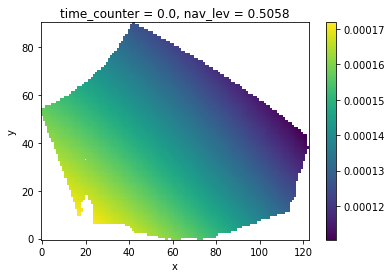

In [14]:
WeightboxBG.plot()

In [7]:
# sshGAIprime = sshGAI - sshGAI.mean("year")
# sshAIprime  = sshAI  - sshAI.mean("year")
# sshSprime   = sshS   - sshS.mean("year")

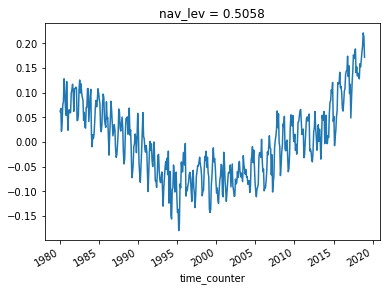

In [16]:
sshGAIboxBG.plot()

In [17]:
diffWP1GAI_S = sshGAIboxBG - sshSboxBG
diffWP1GAI_AI = sshGAIboxBG - sshAIboxBG
diffWP1AI_S = sshAIboxBG -sshSboxBG

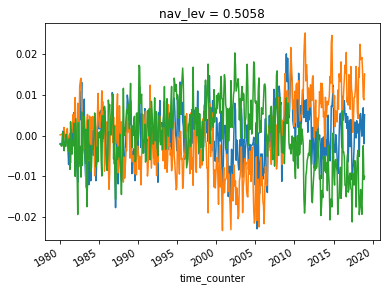

In [18]:
diffWP1GAI_S.plot()
diffWP1GAI_AI.plot()
diffWP1AI_S.plot()

In [19]:
diffWP1GAI_AIshort = diffWP1GAI_AI.sel(time_counter=slice('2005','2018'))
diffWP1AI_Sshort = diffWP1AI_S.sel(time_counter=slice('2005','2018'))
diffWP1GAI_Sshort = diffWP1GAI_S.sel(time_counter=slice('2005','2018'))

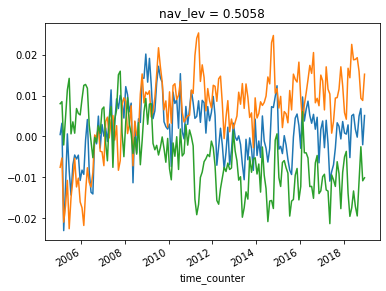

In [20]:
diffWP1GAI_Sshort.plot()
diffWP1GAI_AIshort.plot()
diffWP1AI_Sshort.plot()

In [21]:
diffWP1GAI_AIshort1y = ((diffWP1GAI_AIshort.groupby('time_counter.year').mean('time_counter'))*1000).compute()
diffWP1AI_Sshort1y   = ((diffWP1AI_Sshort.groupby('time_counter.year').mean('time_counter'))*1000).compute()
diffWP1GAI_Sshort1y  = ((diffWP1GAI_Sshort.groupby('time_counter.year').mean('time_counter'))*1000).compute()

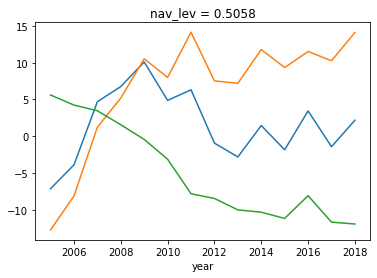

In [22]:
diffWP1GAI_Sshort1y.plot()
diffWP1GAI_AIshort1y.plot()
diffWP1AI_Sshort1y.plot()

In [52]:
lin_GAI_AI = esmtools.stats.linregress(diffWP1GAI_AIshort1y, dim="year")
lin_AI_S = esmtools.stats.linregress(diffWP1AI_Sshort1y, dim="year")
lin_GAI_S = esmtools.stats.linregress(diffWP1GAI_Sshort1y, dim="year")

In [53]:
print(lin_GAI_AI.sel(parameter='slope').values)
print(lin_AI_S.sel(parameter='slope').values)
print(lin_GAI_S.sel(parameter='slope').values)

1.4745899179534554
-1.467488851003902
0.0071010669495535595


In [54]:
from scipy.stats import t

In [55]:
print(lin_GAI_AI.sel(parameter='stderr').values)
print(lin_AI_S.sel(parameter='stderr').values)
print(lin_GAI_S.sel(parameter='stderr').values)

0.34880993698794993
0.1504165907881909
0.3308663351341059


In [56]:
tinv = lambda p, df: abs(t.ppf(p/2, df))

In [57]:
ts = tinv(0.05, 14-2) # = 2.1788

print(f"GR slope (95%): {lin_GAI_AI.sel(parameter='slope').values:.2f}  +/- {ts*lin_GAI_AI.sel(parameter='stderr').values:.2f}")
print(f"RIV slope (95%): {lin_AI_S.sel(parameter='slope').values:.2f}  +/- {ts*lin_AI_S.sel(parameter='stderr').values:.2f}")
print(f"GR+RIV slope (95%): {lin_GAI_S.sel(parameter='slope').values:.2f} +/- {ts*lin_GAI_S.sel(parameter='stderr').values:.2f}")

GR slope (95%): 1.47    +/- 0.76
RIV slope (95%): -1.47     +/- 0.33
GR+RIV slope (95%): 0.01 +/- 0.72
